In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

import utils

# Validation 

In [25]:
cols = [
    'Sample set model',
    "Full data set model",
    "Do average",
    "Simple group mean",
    "Group mean of last month of dataset",
    "RF from last two weeks"]
index = [
    'Random(CV)',              
    'Last Month',
    'Last two weeks',
    'Same date range 1 month earlier'
]
val_df = pd.DataFrame(
    index=index, columns=cols)

In [27]:
val_df

,Sample set model,Full data set model,Do average,Simple group mean,Group mean of last month of dataset,RF from last two weeks
Random(CV),NaN,NaN,NaN,NaN,NaN,NaN
Last Month,NaN,NaN,NaN,NaN,NaN,NaN
Last two weeks,NaN,NaN,NaN,NaN,NaN,NaN
Same date range 1 month earlier,NaN,NaN,NaN,NaN,NaN,NaN


# Data split

In [28]:
PATH = "../../../data/RRVF/" # "../../../data/RRVF/" "/data/"

In [49]:
!ls {PATH}

air_reserve.csv        hpg_reserve.csv        tmp
air_store_info.csv     hpg_store_info.csv     ts_prep.pkl
air_visit_data.csv     models                 valid_set
cat_vars.pkl           sample_submission.csv  weather_data_merge.csv
contin_vars.pkl        store_id_relation.csv
date_info.csv          test_set


In [50]:
def split(df):
    trn_len = int(np.floor(len(df) * 0.9))
    valid_len = len(df) - trn_len
    df['type'] = 0  #0 for train 1 for valid
    indexs = df.index
    df = df.reset_index()
    df.loc[trn_len:, 'type'] =  1
    return df



data_raw = pd.read_csv('{}air_visit_data.csv'.format(PATH))
test = pd.read_csv('{}sample_submission.csv'.format(PATH))
test_data = utils.tes2trn(test)
test_stores = test_data.air_store_id.unique()
data = data_raw[data_raw.air_store_id.isin(test_stores)]
tag_data = data.groupby('air_store_id').apply(split)
t = tag_data.set_index('index')
train_set = t[t.type == 0]
valid_set = t[t.type == 1]
train_set = train_set.reset_index().drop(['index', 'type'], axis=1)
valid_set = valid_set.reset_index().drop(['index', 'type'], axis=1)
test_set = test_data.assign(visitors=0)


data = {
        'tra': pd.read_csv('{}air_visit_data.csv'.format(PATH)),
        'as': pd.read_csv('{}air_store_info.csv'.format(PATH)),
        'hs': pd.read_csv('{}hpg_store_info.csv'.format(PATH)),
        'ar': pd.read_csv('{}air_reserve.csv'.format(PATH)),
        'hr': pd.read_csv('{}hpg_reserve.csv'.format(PATH)),
        'id': pd.read_csv('{}store_id_relation.csv'.format(PATH)),
        'hol': pd.read_csv('{}date_info.csv'.format(PATH))
    }
cat_vars = ['air_store_id', 'visit_Year', 'visit_Month', 'visit_Week', 'visit_Day', 'visit_Dayofweek', 'visit_Dayofyear',
    'visit_Is_month_end', 'visit_Is_month_start', 'visit_Is_quarter_end', 'visit_Is_quarter_start', 'visit_Is_year_end', 'visit_Is_year_start',
    'visit_Elapsed', 'day_of_week'] # default settings

contin_vars = []


for df in (test_set, valid_set, train_set):
    add_datepart(df, "visit_date", drop=False)
    
# ts_prep = pickle.load(open('{}ts_prep.pkl'.format(PATH), 'rb'))
# train_set, cats, contins = utils.add_prop(train_set, ts_prep)
# valid_set, *_ = utils.add_prop(valid_set, ts_prep)
# test_set,*_ = utils.add_prop(test_set, ts_prep)
# cat_vars.extend(cats)
# contin_vars.extend(contins)

# Data Cleaning / Feature Engineering

In [52]:
train_set.visit_date.tail()

225044   2017-03-22
225045   2017-03-23
225046   2017-03-24
225047   2017-03-25
225048   2017-03-26
Name: visit_date, dtype: datetime64[ns]

In [57]:
# wea = pd.read_csv('{}weather_data_merge.csv'.format(PATH))
# train_set, cats, contins = utils.add_wea(train_set, wea)
# valid_set, *_ = utils.add_wea(valid_set, wea)
# test_set, *_ = utils.add_wea(test_set, wea)
# cat_vars.extend(cats)
# contin_vars.extend(contins)

In [53]:
hol = pd.read_csv('{}date_info.csv'.format(PATH))
train_set, cats, contins = utils.add_holiday_stat(train_set, hol)
valid_set, *_ = utils.add_holiday_stat(valid_set, hol)
test_set, *_ = utils.add_holiday_stat(test_set, hol)
train_set.drop('Date', axis=1, inplace=True, errors='ignore')
valid_set.drop('Date', axis=1, inplace=True, errors='ignore')
test_set.drop('Date', axis=1, inplace=True, errors='ignore')
cat_vars.extend(cats)
contin_vars.extend(contins)

In [60]:
import utils
train_set, cats, contins = utils.add_area_loc_stat(train_set, data)
valid_set, *_ = utils.add_area_loc_stat(valid_set, data)
test_set, *_ = utils.add_area_loc_stat(test_set, data)
cat_vars.extend(cats)
contin_vars.extend(contins)

static_attrs = ['area_name', 'air_loc'] # 'air_store_id', ,  'hpg_loc', 
train_set, cats, contins = utils.add_attr_static(train_set, static_attrs)
valid_set, *_ = utils.add_attr_static(valid_set, static_attrs)
test_set, *_= utils.add_attr_static(test_set, static_attrs)
cat_vars.extend(cats)
contin_vars.extend(contins)



In [64]:
train_set.columns

Index(['air_store_id', 'visit_date', 'visitors', 'visit_Year', 'visit_Month',
       'visit_Week', 'visit_Day', 'visit_Dayofweek', 'visit_Dayofyear',
       'visit_Is_month_end', 'visit_Is_month_start', 'visit_Is_quarter_end',
       'visit_Is_quarter_start', 'visit_Is_year_end', 'visit_Is_year_start',
       'visit_Elapsed', 'day_of_week', 'holiday_flg', 'af_holiday_flg',
       'be_holiday_flg', 'dur_time_holiday_flg', 'dur_holiday_flg',
       'dur_prog_holiday_flg', 'genre_name', 'area_name', 'hpg_genre_name',
       'hpg_area_name', 'air_loc', 'hpg_loc', 'stores_in_air_loc',
       'stores_in_hpg_loc', 'stores_in_area_name', 'stores_in_hpg_area_name',
       'min_visits_in_area_name', 'max_visits_in_area_name',
       'mean_visits_in_area_name', 'std_visits_in_area_name',
       'min_visits_in_air_loc', 'max_visits_in_air_loc',
       'mean_visits_in_air_loc', 'std_visits_in_air_loc'],
      dtype='object')

In [66]:
for df in [train_set, valid_set, test_set]:
    df.visit_date = df.visit_date.dt.date

In [67]:
train_set.to_feather(f'{PATH}train_set')
valid_set.to_feather(f'{PATH}valid_set')
test_set.to_feather(f'{PATH}test_set')
pickle.dump(contin_vars, open(f'{PATH}contin_vars.pkl', 'wb'))
pickle.dump(cat_vars, open(f'{PATH}cat_vars.pkl','wb'))

# TBD

In [29]:
train_set = pd.read_feather(f'{PATH}train_set')
valid_set = pd.read_feather(f'{PATH}valid_set')
test_set = pd.read_feather(f'{PATH}test_set')

contin_vars = pickle.load(open(f'{PATH}contin_vars.pkl', 'rb'))
cat_vars = pickle.load(open(f'{PATH}cat_vars.pkl','rb'))


# Create feature

In [5]:


dep = 'visitors'

n = len(train_set); n

train_set = train_set[cat_vars+contin_vars+[dep, 'visit_date']].copy()
valid_set = valid_set[cat_vars+contin_vars+[dep, 'visit_date']].copy()
test_set = test_set[cat_vars+contin_vars+[dep, 'visit_date']].copy()

for v in cat_vars: 
    train_set[v] = train_set[v].astype('category').cat.as_ordered()

apply_cats(test_set, train_set)
apply_cats(valid_set, train_set)

test_set = test_set.set_index("visit_date")
valid_set = valid_set.set_index("visit_date")
train_set = train_set.set_index("visit_date")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/fastai-0.6-py3.6.egg/fastai/structured.py:198: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)


In [9]:
df, y, nas, mapper = proc_df(train_set, 'visitors', do_scale=True)
yl = np.log(y)
df_val, y_val, _, _ = proc_df(valid_set, 'visitors', do_scale=True, #  skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)
df_test, _, _, _ = proc_df(test_set, 'visitors', do_scale=True, # skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)
y2 = np.log(y_val)

# Random Forest

In [13]:
X_train, y_train = df, np.log1p(y)
X_valid, y_valid = df_val, np.log1p(y_val)

In [14]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [15]:
set_rf_samples(50000)

In [16]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.4755483370023806, 0.6840911392228864, 0.65221183783170433, 0.31056128052962528, 0.56645913345452859]


In [17]:
fi = rf_feat_importance(m, train_set); fi[:10]

,cols,imp
0,air_store_id,0.257650
21,genre_name,0.101116
5,visit_Dayofweek,0.095451
13,visit_Elapsed,0.078246
32,mean_visits_in_air_loc,0.067720
4,visit_Day,0.062391
6,visit_Dayofyear,0.060334
33,mean_visits_in_area_name,0.046468
3,visit_Week,0.041742
25,air_loc,0.021079


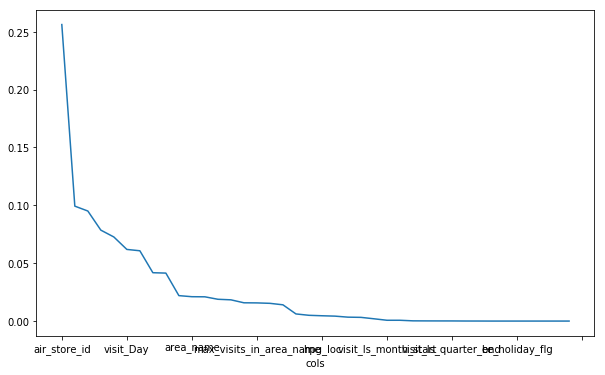

In [77]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [22]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

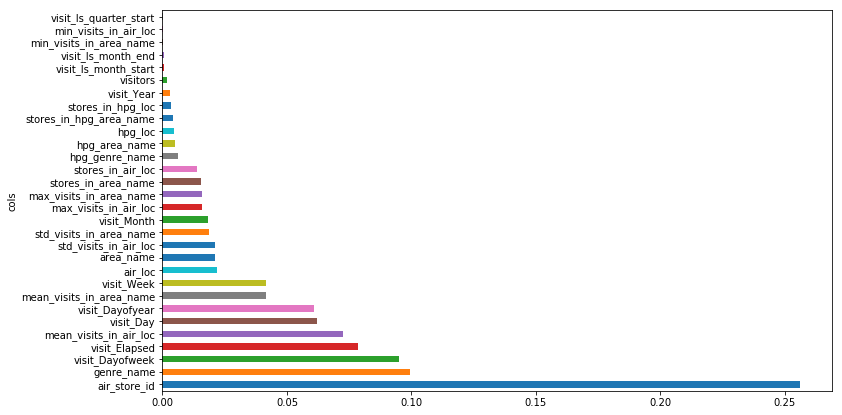

In [79]:
plot_fi(fi[:30]);

In [18]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

21

In [19]:
X_train, X_valid = df[to_keep].copy(), df_val[to_keep].copy()

In [20]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.47600648925696354, 0.677526546760512, 0.65154138364751057, 0.32372961028013514, 0.56577246866766928]


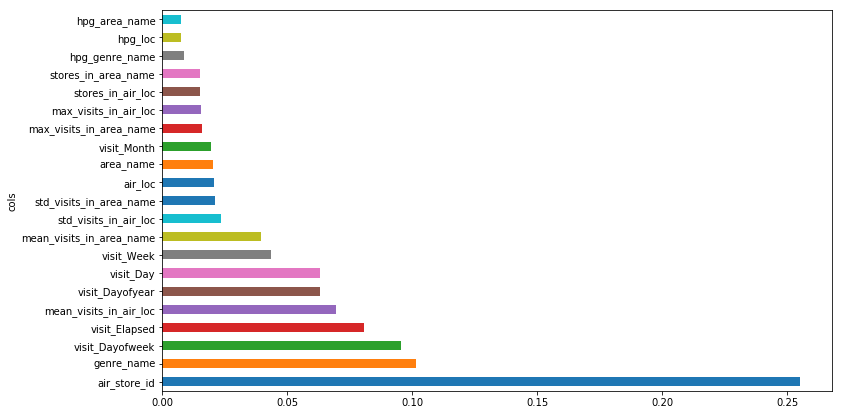

In [23]:
fi = rf_feat_importance(m, X_train)
plot_fi(fi);

In [90]:
train_set.genre_name.unique()

[Italian/French, Izakaya, Dining bar, Cafe/Sweets, Japanese food, ..., Asian, Bar/Cocktail, Creative cuisine, International cuisine, Karaoke/Party]
Length: 14
Categories (14, object): [Asian < Bar/Cocktail < Cafe/Sweets < Creative cuisine ... Okonomiyaki/Monja/Teppanyaki < Other < Western food < Yakiniku/Korean food]

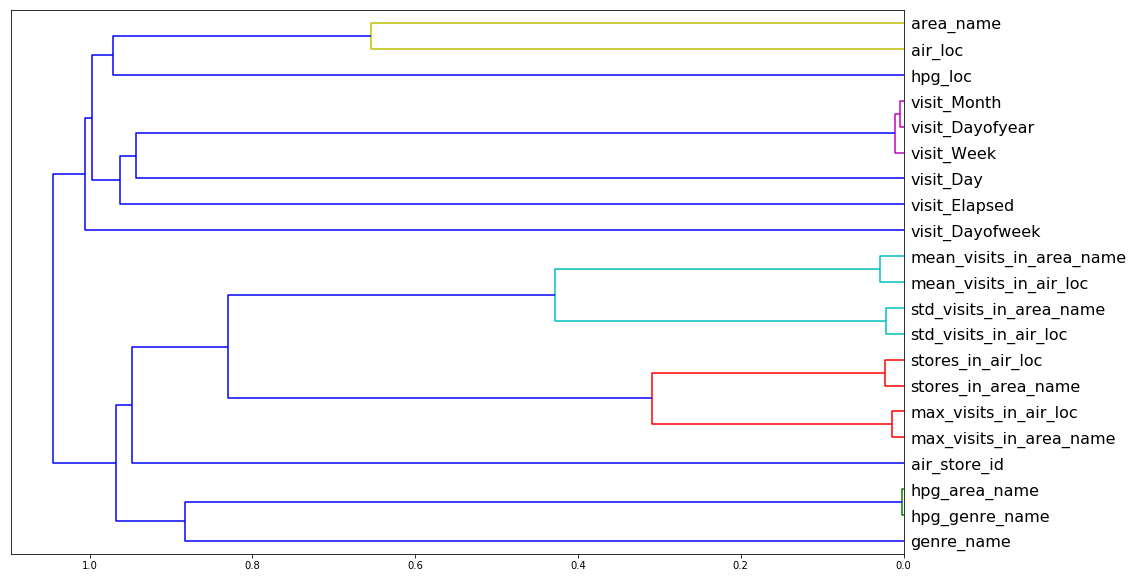

In [26]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

In [29]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    m.fit(df, y_train)
    return m.oob_score_

In [30]:
get_oob(X_train)

0.56320014882991987

In [32]:
for c in ('hpg_area_name', 'hpg_genre_name', 'max_visits_in_area_name', 'max_visits_in_air_loc','visit_Month', 'visit_Dayofyear'):
    print(c, get_oob(X_train.drop(c, axis=1)))

hpg_area_name 0.565858719613
hpg_genre_name 0.565035825934
max_visits_in_area_name 0.56503867672
max_visits_in_air_loc 0.565329049212
visit_Month 0.566242998261
visit_Dayofyear 0.566272068843


In [33]:
reset_rf_samples()

In [34]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.36179922521130875, 0.676993103351176, 0.79869214280979817, 0.32479409983233809, 0.57243590199522287]


# Partial dependence

In [36]:
from pdpbox import pdp
from plotnine import *

In [37]:
set_rf_samples(50000)

In [38]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

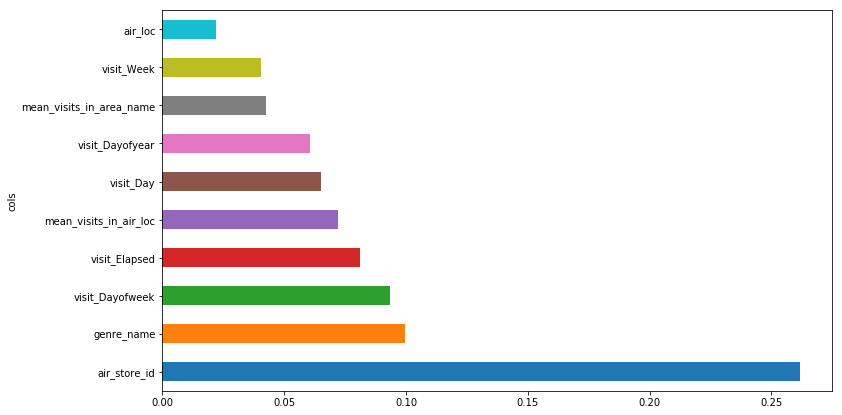

In [41]:
plot_fi(rf_feat_importance(m, X_train)[:10]);

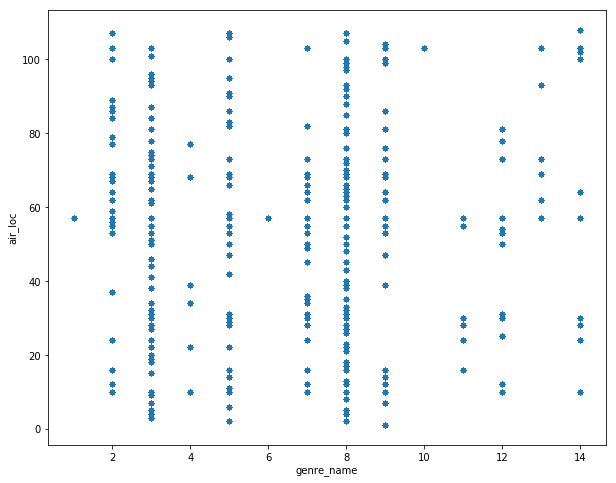

In [46]:
X_train.plot('genre_name', 'air_loc', 'scatter', alpha=0.01, figsize=(10,8));

In [ ]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [47]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 202 ms, sys: 40.7 ms, total: 243 ms
Wall time: 242 ms


(3.4392016761615194, 0.60899233236474881)

In [48]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 87.4 ms, sys: 80.6 ms, total: 168 ms
Wall time: 304 ms


(3.4392016761615194, 0.60899233236474881)

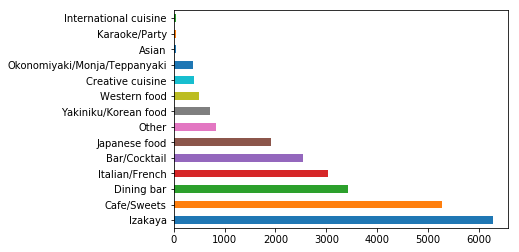

In [51]:
x = valid_set.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.genre_name.value_counts().plot.barh();

In [54]:
flds = ['genre_name', 'visitors', 'pred', 'pred_std']
enc_summ = x[flds].groupby('genre_name', as_index=False).mean()
enc_summ

,genre_name,visitors,pred,pred_std
0,Asian,37.127273,2.873264,0.796646
1,Bar/Cocktail,13.279608,2.368110,0.602758
2,Cafe/Sweets,23.337569,3.009520,0.630609
3,Creative cuisine,26.486005,3.062032,0.648814
4,Dining bar,18.820835,2.752250,0.683347
5,International cuisine,26.410256,2.933772,0.870651
6,Italian/French,22.712401,2.970162,0.696028
7,Izakaya,23.771219,2.970354,0.631278
8,Japanese food,19.475616,2.883718,0.683474
9,Karaoke/Party,34.641509,3.081506,0.740399


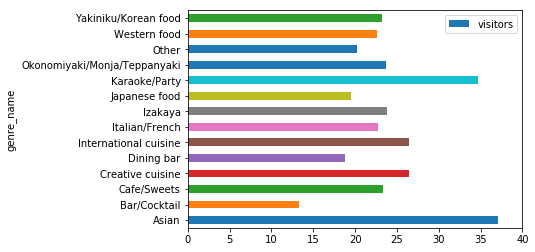

In [58]:
enc_summ = enc_summ[~pd.isnull(enc_summ.genre_name)]
enc_summ.plot('genre_name', 'visitors', 'barh', xlim=(0,40));

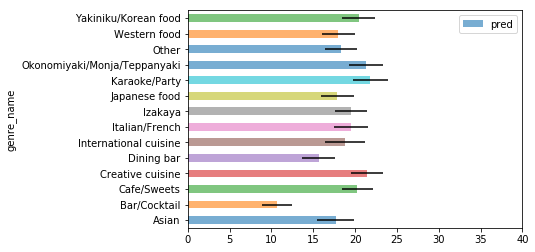

In [63]:

enc_summ.plot('genre_name', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,40));

In [ ]:
enc_summ.pred = np.exp(enc_summ.pred)

In [62]:
enc_summ.pred_std = np.exp(enc_summ.pred_std)

In [64]:
(enc_summ.pred_std/enc_summ.pred).sort_values(ascending=False)

1     0.171126
5     0.127057
4     0.126324
0     0.125353
8     0.110776
12    0.110359
11    0.104088
6     0.102886
7     0.096417
9     0.096221
13    0.095343
10    0.095107
2     0.092651
3     0.089527
dtype: float64

In [65]:
enc_summ

,genre_name,visitors,pred,pred_std
0,Asian,37.127273,17.694677,2.218089
1,Bar/Cocktail,13.279608,10.677196,1.827150
2,Cafe/Sweets,23.337569,20.277655,1.878754
3,Creative cuisine,26.486005,21.370933,1.913270
4,Dining bar,18.820835,15.677862,1.980495
5,International cuisine,26.410256,18.798410,2.388465
6,Italian/French,22.712401,19.495079,2.005771
7,Izakaya,23.771219,19.498812,1.880011
8,Japanese food,19.475616,17.880624,1.980747
9,Karaoke/Party,34.641509,21.791195,2.096772


# Tree interpreter


In [67]:
from treeinterpreter import treeinterpreter as ti

In [68]:
row = X_valid.values[None,0]; row

array([[   1.     ,    7.     ,    6.     ,  450.     ,    1.83413,   25.     ,   84.     ,    1.88624,
          12.     ,   69.     ,   45.     ,    1.40543,    1.42265,    3.     ,   -0.68605,   -0.18596,
          -0.67694,   -0.1581 ,    0.     ,   35.     ,    0.     ]])

In [69]:
prediction, bias, contributions = ti.predict(m, row)

In [70]:
prediction[0], bias[0]

(3.4392016761615194, 2.8002709957732206)

In [71]:
idxs = np.argsort(contributions[0])

In [73]:
[o for o in zip(X_train.columns[idxs], X_train.iloc[0][idxs], contributions[0][idxs])]

[('visit_Elapsed', 183.0, -0.071514926613036184),
 ('air_loc', 69.0, -0.016864963159615231),
 ('stores_in_air_loc', -0.15810222944651017, -0.012196819936200165),
 ('area_name', 45.0, -0.011989975220242621),
 ('visit_Dayofyear', 183.0, -0.0051088356225353349),
 ('hpg_genre_name', 0.0, 0.0034689967357795061),
 ('std_visits_in_area_name', 0.9717744944336782, 0.0083173268337478519),
 ('hpg_loc', 35.0, 0.012676410884746914),
 ('max_visits_in_air_loc', -0.5084147876939403, 0.013161828844448598),
 ('stores_in_area_name', -0.18596131089351278, 0.014877503610547427),
 ('genre_name', 7.0, 0.015185691376606358),
 ('visit_Month', 7.0, 0.015746843540219858),
 ('visit_Day', 1.0, 0.016314787128898268),
 ('visit_Week', 26.0, 0.020107236634243318),
 ('std_visits_in_air_loc', 0.964317762725145, 0.023366772205020658),
 ('air_store_id', 1.0, 0.025112464677193413),
 ('hpg_area_name', 0.0, 0.035259543478246724),
 ('max_visits_in_area_name', -0.5185350940077101, 0.036990592214938833),
 ('mean_visits_in_area_

In [74]:
contributions[0].sum()

0.63893068038829837

# Extrapolation

In [80]:
df_ext = pd.concat((X_train.copy(), X_valid.copy()))
df_ext['is_valid'] = 1
df_ext.is_valid[:len(X_train)] = 0
x, y, _ = proc_df(df_ext, 'is_valid')

In [81]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9988541450404842

In [82]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
3,visit_Elapsed,0.607622
6,visit_Dayofyear,0.082584
8,visit_Week,0.057169
14,max_visits_in_area_name,0.053746
16,max_visits_in_air_loc,0.041384
17,stores_in_air_loc,0.037159
13,visit_Month,0.026922
15,stores_in_area_name,0.020840
11,std_visits_in_air_loc,0.019514
12,std_visits_in_area_name,0.016232


In [83]:
feats=['visit_Elapsed', 'visit_Dayofyear', 'visit_Week']

In [84]:
(X_train[feats]/1000).describe()

,visit_Elapsed,visit_Dayofyear,visit_Week
count,225049.000000,225049.000000,225049.000000
mean,0.267299,0.182896,0.026270
std,0.114545,0.115288,0.016392
min,0.001000,0.001000,0.001000
25%,0.196000,0.062000,0.009000
50%,0.279000,0.202000,0.029000
75%,0.359000,0.285000,0.041000
max,0.476000,0.366000,0.053000


In [85]:
(X_valid[feats]/1000).describe()

,visit_Elapsed,visit_Dayofyear,visit_Week
count,25419.000000,25419.000000,25419.000000
mean,0.430037,0.093751,0.013671
std,0.110584,0.015042,0.002156
min,0.000000,0.035000,0.005000
25%,0.449000,0.085000,0.012000
50%,0.458000,0.095000,0.014000
75%,0.468000,0.104000,0.015000
max,0.476000,0.363000,0.052000


In [86]:
x.drop(feats, axis=1, inplace=True)

In [87]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99990018685021642

In [88]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,visit_Month,0.331620
11,max_visits_in_area_name,0.163644
13,max_visits_in_air_loc,0.117868
14,stores_in_air_loc,0.107236
9,std_visits_in_area_name,0.056961
12,stores_in_area_name,0.049920
8,std_visits_in_air_loc,0.046896
5,mean_visits_in_area_name,0.037133
3,mean_visits_in_air_loc,0.028752
6,air_loc,0.025400


In [89]:
feats=['visit_Elapsed', 'visit_Dayofyear', 'visit_Week', 'visit_Month', 'max_visits_in_area_name']

In [91]:
for f in feats:
    df_subs = X_train.drop(f, axis=1).copy()
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df_subs, y_train)
    print(f)
    print_score(m)

visit_Elapsed


ValueError: Number of features of the model must match the input. Model n_features is 20 and input n_features is 21 

# DL

In [102]:
def inv_y(a): return np.exp(a)

def rmsle(y_pred, targ):
#     targ = inv_y(targ)
    log_vars = np.log(targ + 1) - np.log(y_pred + 1)
    return math.sqrt(np.square(log_vars).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [103]:
md = ColumnarModelData.from_data_frames(PATH, df, df_val, yl.astype(np.float32), y2.astype(np.float32), cat_flds=cat_vars, bs=128, test_df=df_test)

In [104]:
cat_sz = [(c, len(train_set[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [105]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [106]:
m.lr_find()


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  3%|▎         | 54/1759 [00:02<01:26, 19.65it/s, loss=0.893]

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 59%|█████▉    | 1034/1759 [00:14<00:09, 72.91it/s, loss=1.36] 


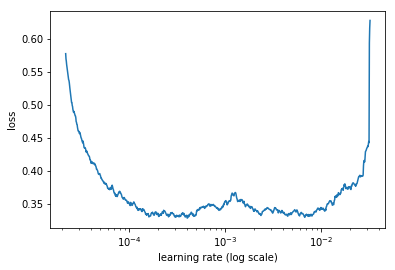

In [107]:
m.sched.plot(100)

In [108]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-4/1.1

In [109]:
m.fit(lr, 3, metrics=[rmsle])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   rmsle                         
    0      0.318883   0.343378   0.210507  
    1      0.30198    0.324165   0.208273                      
    2      0.307295   0.338393   0.209531                      



[0.3383929, 0.2095314960915929]

In [116]:
lr = 1e-4
m.fit(lr, 20, metrics=[rmsle], cycle_len=3, cycle_mult=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=60), HTML(value='')))

epoch      trn_loss   val_loss   rmsle                         
    0      0.292008   0.340122   0.210913  
    1      0.280181   0.348281   0.211798                      
    2      0.287628   0.35659    0.21342                       
    3      0.290715   0.348601   0.213467                      
    4      0.275758   0.355558   0.213066                      
    5      0.279356   0.359688   0.214379                      
    6      0.289535   0.368537   0.216161                      
    7      0.283198   0.360726   0.214673                      
    8      0.274161   0.363977   0.215295                      
    9      0.282894   0.360507   0.215914                      
 13%|█▎        | 225/1759 [00:04<00:31, 48.22it/s, loss=0.273]

KeyboardInterrupt: 

 13%|█▎        | 225/1759 [00:20<02:16, 11.24it/s, loss=0.273]

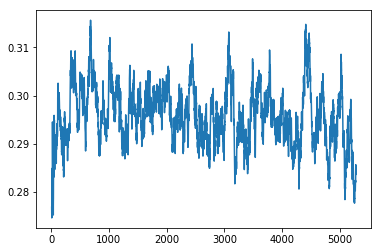

In [114]:
m.sched.plot_loss()

In [115]:
x,y=m.predict_with_targs()
rmsle(x,y)

0.21373713471361197

In [28]:
contin_vars


['prop_yhat_lower',
 'prop_yhat_upper',
 'prop_yhat',
 'stores_in_air_loc',
 'stores_in_hpg_loc',
 'stores_in_area_name',
 'stores_in_hpg_area_name',
 'min_visits_in_air_store_id',
 'max_visits_in_air_store_id',
 'mean_visits_in_air_store_id',
 'std_visits_in_air_store_id',
 'min_visits_in_air_loc',
 'max_visits_in_air_loc',
 'mean_visits_in_air_loc',
 'std_visits_in_air_loc',
 'min_visits_in_hpg_loc',
 'max_visits_in_hpg_loc',
 'mean_visits_in_hpg_loc',
 'std_visits_in_hpg_loc',
 'min_visits_in_area_name',
 'max_visits_in_area_name',
 'mean_visits_in_area_name',
 'std_visits_in_area_name',
 'min_visits_in_hpg_area_name',
 'max_visits_in_hpg_area_name',
 'mean_visits_in_hpg_area_name',
 'std_visits_in_hpg_area_name']

In [34]:
cat_sz


[('air_store_id', 822),
 ('visit_Year', 3),
 ('visit_Month', 13),
 ('visit_Week', 54),
 ('visit_Day', 32),
 ('visit_Dayofweek', 8),
 ('visit_Dayofyear', 367),
 ('visit_Is_month_end', 3),
 ('visit_Is_month_start', 3),
 ('visit_Is_quarter_end', 3),
 ('visit_Is_quarter_start', 3),
 ('visit_Is_year_end', 3),
 ('visit_Is_year_start', 3),
 ('visit_Elapsed', 477),
 ('day_of_week', 8),
 ('holiday_flg', 3),
 ('af_holiday_flg', 75),
 ('be_holiday_flg', 75),
 ('dur_time_holiday_flg', 8),
 ('dur_holiday_flg', 6),
 ('dur_prog_holiday_flg', 8),
 ('genre_name', 15),
 ('area_name', 72),
 ('hpb_genre_name', 16),
 ('hpb_area_name', 33),
 ('air_loc', 74),
 ('hpb_loc', 34)]

In [387]:
csv_fn=f'sub1.csv'
pred_test=m.predict(True)
pred_test = np.exp(pred_test)
test_set['visitors']=pred_test
sub = utils.trn2test(test_set.reset_index()[['air_store_id', 'visit_date', 'visitors']])
sub.to_csv(csv_fn, index=False)

In [388]:
FileLink(csv_fn)


/notebooks/sub1.csv

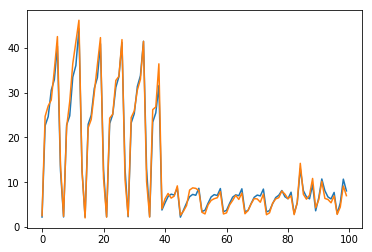

In [326]:
plt.plot(test_set.prop_yhat.values[:100])
plt.plot(pred_test[:100])

In [95]:
np.exp(0.044)

1.0449823548884438

In [96]:
np.exp(np.log1p(30) - 0.044)

29.665572681664447